# Decision Tree Regression and Boosting

While it may not be apparent how to use trees for regression analysis, it requires only a straightforward modification to the algorithm. A popular tree-based regression algorithm is the **classification and regression tree** (CART).

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. We can use a decision tree regression model to fit the data.

In [29]:
daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)



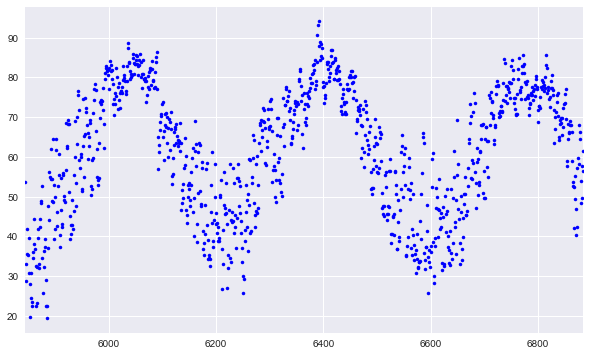

In [30]:
daily_temps.temp[daily_temps.year>2010].plot(style='b.', figsize=(10,6))

In this context, none of the cost functions considered so far would be appropriate. Instead, it would be more suitable to use something like mean squared error (MSE) to guide the growth of the tree. With this, we can proceed to choose:

1. a variable on which to split the dataset
2. a value of the variable at which to place a node (in the case of continuous features)

Recall that the output of a tree is just a constant value for each leaf; here, we simply return the average of all the response values in the region. Thus, we choose a cut point that minimizes the MSE at each step.

In [31]:
# Transmogrify data
y = daily_temps.temp[daily_temps.year>2010]
X = np.atleast_2d(np.arange(len(y))).T

In [32]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=7, min_samples_leaf=2)
clf.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

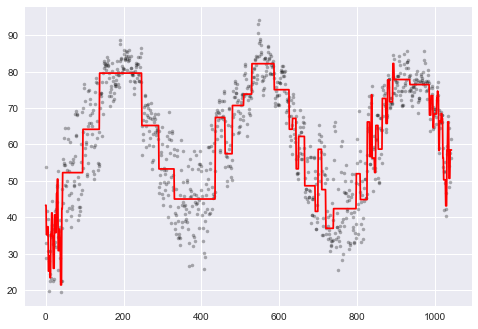

In [33]:
X_fit = np.linspace(0, len(X), 1000).reshape((-1, 1))
y_fit_1 = clf.predict(X_fit)

plt.plot(X.ravel(), y, '.k', alpha=0.3)
plt.plot(X_fit.ravel(), y_fit_1, color='red');

A single decision tree allows us to estimate the signal in a non-parametric way,
but clearly has some issues.  In some regions, the model shows high bias and
under-fits the data
(seen in the long flat lines which don't follow the contours of the data),
while in other regions the model shows high variance and over-fits the data
(reflected in the narrow spikes which are influenced by noise in single points).

One way to address this is to use an **ensemble method**, so that the
effects of their over-fitting go away on average. 

## Boosting

Another effective ensemble method for classification and regression is gradient boosting, or **boosting**. Boosting was originally derived in the computational learning theory literature, where it was proved that one could boost the performance of any "weak" learner arbitrarily high, provided the weak learner could always perform slightly better than chance. The idea is that by sequentially applying very fast, simple models, we can get a total model error which is better than any of the individual pieces. Hastie and Tibshirani describe it as:

> one of the most powerful learning ideas introduced in the last twenty years.


## AdaBoost

One of the simplest and most prevalent boosting algorithms is the **AdaBoost.M1** method by [Freund and Schapire (1997)](http://www.sciencedirect.com/science/article/pii/S002200009791504X), which aims to improve the accuracy of *any* learning algorithm.

If we consider a binary output, coded as $Y \in \{-1,1\}$. We can define the error rate of some classifier $G(X)$ as:

$$\overline{err} = \frac{1}{N} \sum_{i=1}^N I[y_i \ne G(x_i)]$$

A classifier is called a *weak* classifier when its error rate is only marginally better than random selection of outcomes. Boosting takes a weak classifier and applies it sequentially to data which have been weighted by having been passed through previous iterations of the classifier. A final prediction is produced by a weighted majority vote from all the classifiers.

![adaboost](http://d.pr/i/1bTsQ+)

Thus, the $\alpha_m$ values are calculated by the classifier, and are used to weight the estimates in generating a final prediction. Observations that are misclassified by a given classifier are weighted more heavily so that they are given more emphasis in subsequent classification steps. Hence, observations that are more troublesome are given increasing influence, until they are classified correctly.

### AdaBoost.M1

1. Initialize observation weights uniformly: $w_i = 1/N$
2. Iterate $m=1,\ldots,M$:
    + Fit classifier $G_m(x)$ to trainging data, weighted by $w_i$
    + Calculate weighted classification error:
    $$\text{err}_m = \frac{\sum_i w_i I[y_i \ne G_m(x_i)]}{\sum_i w_i}$$
    + Compute $\alpha_m = \log[(1-\text{err}_m)/\text{err}_m]$
    + Recalculate weights: $w_i = w_i \exp(a_m I[y_i \ne G_m(x_i)])$
3. Return $G(x) = \text{sign}[\sum_m \alpha_m G_m(x)]$


Boosting is simply a form of forward stagewise additive modeling. It is a particular type of basis function expansion, of the general form:

$$f(x | \{\beta_m, \theta_m\}) = \sum_{m=1}^M \beta_m b(x | \theta_m)$$

where the $\beta_m$ are expansion coefficients and $b$ some multivariate function parameterized by $\theta_m$. We saw an example of such basis expansions in the previous section on decision trees, where the $b$ are internal nodes and the predictions are terminal nodes.

These models are fit by minimizing some loss function:

$$\min_{\{\beta_m, \theta_m\}} \sum_{i=1}^N L(y_i, f(x | \{\beta_m, \theta_m\})$$

We can approximate the optimization by adding the next basis function to a set of existing functions, without adjusting the parameters of the functions already added.

The algorithm is as follows:

1. Initialize $f_0(x) = 0$
2. Iterate $m=1,\ldots,M$:
    + Optimize:
    $$(\beta_m, \theta_m) = \text{argmin}_{\beta, \theta} \sum_{i=1}^N L(y_i, f_{m-1}(x_i) + \beta_m b(x|\theta_m))$$
    + Set $f_m(x) = f_{m-1}(x) + \beta_m b(x|\theta_m)$
    
We can use a function such as squared-error loss.

Returning to AdaBoost.M1, we can use an exponential loss function:

$$L(y, f(x)) = \exp(-y \alpha G(x))$$

which means we need to calculate:

$$(\alpha_m, G_m) = \text{argmin}_{\alpha, G} \sum_{i=1}^N w_i^{(m)} \exp[-y_i \alpha G(x_i)]$$

where the weights are:

$$w_i^{(m)} = \exp[-y_i f_{m-1}(x)] $$

Let's implement this algorithm in Python, and run it on some artificial data, which consists of two predictors, simulated from a uniform random number generator, with the class label set to 1 where both values are greater than 0.4, and -1 otherwise.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

ndata = 50

train_data = np.random.rand(2, ndata)
train_classes = np.where(((train_data[0,:]>0.4) & (train_data[1,:]>0.4)),1,-1)

test_data = np.random.rand(2,ndata)
test_classes = np.where(((test_data[0,:]>0.4) & (test_data[1,:]>0.4)),1,-1)

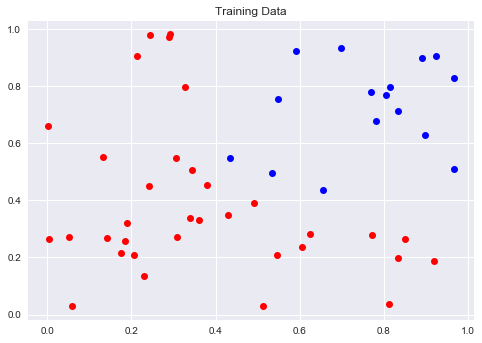

In [2]:
plt.plot(train_data[0, np.where(train_classes==-1)], train_data[1, np.where(train_classes==-1)],'ro')
plt.plot(train_data[0, np.where(train_classes==1)], train_data[1, np.where(train_classes==1)],'bo')
plt.title('Training Data');

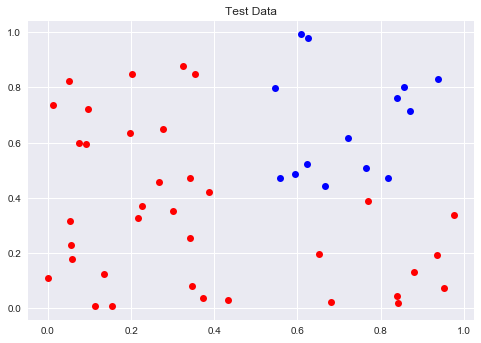

In [3]:
plt.plot(test_data[0, np.where(test_classes==-1)], test_data[1, np.where(test_classes==-1)],'ro')
plt.plot(test_data[0, np.where(test_classes==1)], test_data[1, np.where(test_classes==1)],'bo')
plt.title('Test Data');

We can specify a very simple weak classifier that generates a class label by fitting only one of the two predictor variables, based on a threshold value.

In [4]:
def classify(data, true_classes, value):
    
    # Classify
    classes = np.where(data<value, -1, 1)
    
    # Misclassification
    wrong = np.where(true_classes!=classes, 1, 0)
    
    return classes, wrong


In [5]:
classify(train_data[0], train_classes, 0.1)

(array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1]),
 array([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 1]))

Our training function calculates the error over a range of classifier values.

In [6]:
def train(data, true_classes, weights):
        
    error = np.zeros(10)
    
    for value in range(10):
        
        val = value/10.
        classes = np.where(data<val, -1, 1)
        error[value] = np.sum(weights[np.where(true_classes!=classes)])

    return np.argmin(error)/10.

In [7]:
train(train_data[1], train_classes, np.ones(len(train_data[0]), float)/len(train_data[0]))

0.59999999999999998

The function below runs the AdaBoost algorithm, with an exponential loss function.

In [8]:
np.random.seed(42)
def adaboost(x_train, y_train, x_test, y_test, M=20):
    
    # Number of variables and training points
    K, N = np.shape(x_train)
    
    classifier = np.zeros(M)
    alpha = np.zeros(M)
    var = np.zeros(M, int)
    
    # Initial model weights
    w = np.ones(N, float)/N

    train_errors = np.zeros(M)
    test_errors = np.zeros(M)
    
    pred_train = np.zeros((M, N))
    pred_test = np.zeros((M, N))
    
    for m in range(M):
        
        # Pick random variable to use as classifier
        var[m] = np.random.binomial(1, 0.5)
        
        # Run classifier on variable using training x_train
        classifier[m] = train(x_train[var[m]], y_train, w)
        
        # Classify training and test x_train
        train_classes, train_error = classify(x_train[var[m]], y_train, classifier[m])
        test_classes, test_error = classify(x_test[var[m]], y_test, classifier[m])

        weighted_error = np.sum(w*train_error)/w.sum()
            
        if m and (weighted_error==0 or weighted_error>=0.5):
            M=m
            print('exiting at',m)
            break

        alpha[m] = np.log((1-weighted_error)/weighted_error)
        
        # Update weights
        w *= np.exp(alpha[m]*train_error)
        w /= np.sum(w)

        train_classes = np.zeros((N, m))
        test_classes = np.zeros((N, m))
        for i in range(m):
            train_classes[:, i], _ = classify(x_train[var[i]], y_train, classifier[i])
            test_classes[:, i], _ = classify(x_test[var[i]], y_test, classifier[i])

        # Make prediction based on series of boosted weak learners
        for n in range(N):
            pred_train[m, n] = np.sum(alpha[:m]*train_classes[n])/alpha.sum()
            pred_test[m, n] = np.sum(alpha[:m]*test_classes[n])/alpha.sum() 
            
        # Classify based on the sum of the weighted classes
        pred_train_classes = np.where(pred_train[m]>0, 1, -1)
        pred_test_classes = np.where(pred_test[m]>0, 1, -1)
        
        train_errors[m] = sum(pred_train_classes!=y_train)
        test_errors[m] = sum(pred_test_classes!=y_test)
    
    plt.plot(np.arange(M), train_errors[:M]/N,'k-', np.arange(M), test_errors[:M]/N,'k--')
    plt.legend(('Training error','Test error'))
    plt.xlabel('Iterations')
    plt.ylabel('Error')


exiting at 15


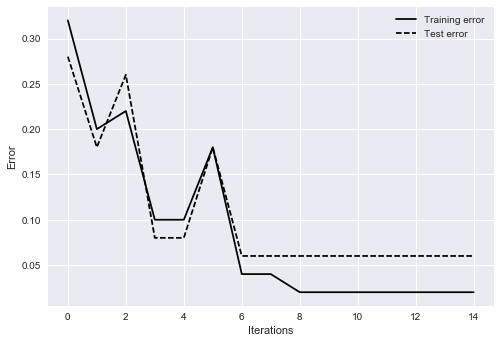

In [9]:
adaboost(train_data, train_classes, test_data, test_classes)

So, the algorithm takes what is a weak classifier and iteratively builds a strong ensemble classifier.

A similar approach can be applied to decision trees, whereby the simplest possible tree (depth=1) is used as a weak classifier at each step. This is often *worse* than random chance for classification at the outset, but when boosting is applied, the resulting classifier can be powerful. This approach to ensemble decision tree learning is called **stumping**.

## Boosting Trees

Recall that for decision trees, we partition the space of all predictor variables into disjoint regions $R_j$, where some constant value $\gamma_j$ (e.g. a mean) is returned for any points in the parameter space located within $R_j$. Formally, we can express a tree as:

$$T(x|\{R_j, \gamma_j\}) = \sum_{j=1}^J \gamma_j I(x \in R_j)$$

The optimization required to find the best parameters is computationally difficult, and we typically fall back on growing and pruning strategies to obtain a competitive solution that is not guaranteed to be optimal.

An alternative approach is to apply boosting to tree-building, which is just a sum of trees:

$$f_M(x) = \sum_{m=1}^M T(x| \{ R_{j}, \gamma_{j} \}_m)$$

induced in a stagewise manner. Specifically, at each step we solve:

$$(R_m, \gamma_m) = \text{argmin}_{R, \gamma} \sum_{i=1}^N L(y_i, f_{m-1}(x_i) + T(x_i| \{R_j, \gamma_j\}_m))$$

where $L$ is a chosen loss function.

So, we can implement the AdaBoost method here. 

However, solving the optimization above is difficult, so we fall back on numerical optimization to approximate a solution.


### Gradient Tree Boosting Algorithm

1. Initialize $f_0(x) = \text{argmin}_{\gamma} \sum_i L(y_i, \gamma)$
2. Iterate from m=1 to M:
    + For all $i=1,\ldots,N$ calculate:
    $$r_{im} = - \left[\frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}\right]_{f=f_{m-1}}$$
    + Fit a tree to $r_{im}$ and determine regions $R_{jm}$
    + Compute: 
    $$\gamma_{jm} = \text{argmin}_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, f_{m-1}(x_i)\gamma)$$
    + Update: 
    $$f_m(x) = f_{m-1}(x) + \sum_j \gamma_{jm} I(x\in R_{jm})$$
3. Return boosted model: $\hat{f}(x) =f_m(x)$

It turns out, for squared error loss the negative gradient is just the **residual**:

$$r_{im} = y_i - f_{m-1}(x_i)$$

Thus, successive trees are fit to the residuals from the current model. The new tree is added to the function, and the residuals are updated.

Thus, for regression problems, boosting is a form of **functional gradient descent**. Boosting is a numerical optimization technique for minimizing the loss function by adding, at each step, a new tree that best reduces (by stepping down the gradient) the cost function. For boosted regression trees, the first regression tree is the one that, for the selected tree size, maximally reduces the loss function. For subsequent steps, the focus is on the residuals: on variation in the response that is not so far explained by the model.

The process is *stagewise*, meaning that existing trees are left unchanged as the model is enlarged. Only the fitted value for each observation is re-estimated at each step to reflect the contribution of the newly added tree. The final model is a linear combination of many trees (usually hundreds to thousands) that can be thought of as a regression model where each term itself is a tree.

The example below presents a simple artificial problem, generated from a sinoid function with random Gaussian noise. There are 100 training points (blue) for fitting the model and 100 test data points (red) which for evaluating the approximation.

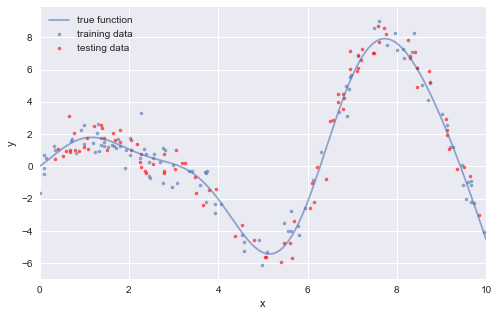

In [10]:
np.random.seed(13)

def true_model(x):
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    x = np.random.uniform(0, 10, size=n_samples)
    x.sort()
    y = true_model(x) + 0.75 * np.random.normal(size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    x_train, y_train = x[train_mask, np.newaxis], y[train_mask]
    x_test, y_test = x[~train_mask, np.newaxis], y[~train_mask]
    
    return x_train, x_test, y_train, y_test
    

X_train, X_test, y_train, y_test = gen_data(200)

x_plot = np.linspace(0, 10, 500)

def plot_data(alpha=0.6):
    
    plt.figure(figsize=(8, 5))
    gt = plt.plot(x_plot, true_model(x_plot), alpha=alpha, label='true function')

    # plot training and testing data
    plt.scatter(X_train, y_train, s=10, alpha=alpha, label='training data')
    plt.scatter(X_test, y_test, s=10, alpha=alpha, color='red', label='testing data')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(loc='upper left')
    
plot_data()

Scikit-learn provides two estimators for gradient boosting: `GradientBoostingClassifier` and `GradientBoostingRegressor`, both are located in the `sklearn.ensemble` submodule. The relevant hyperparameters for these estimators include:

  * number of regression trees (`n_estimators`)
  * depth of each individual tree (`max_depth`)
  * loss function (`loss`)
  * learning rate (`learning_rate`)

If you fit an individual regression tree to the above data you get a piece-wise constant approximation. The deeper you grow the tree the more constant segments you can accomodate thus the more variance you can capture.

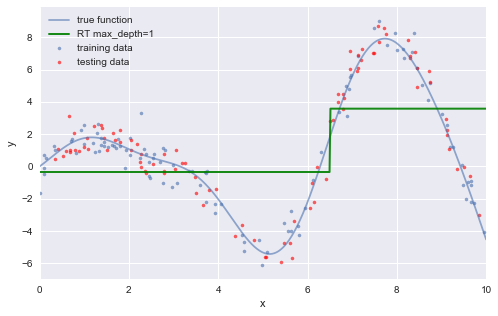

In [11]:
from sklearn.tree import DecisionTreeRegressor

plot_data()
est = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=1', color='g', alpha=0.9, linewidth=2)
plt.legend(loc='upper left');

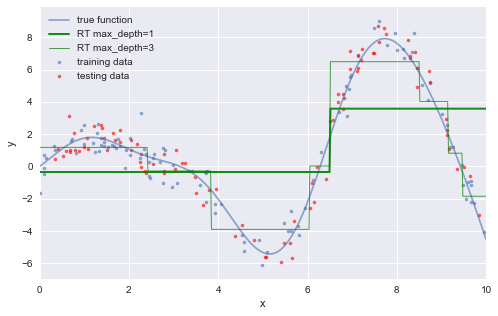

In [12]:
from sklearn.tree import DecisionTreeRegressor

plot_data()
est = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=1', color='g', alpha=0.9, linewidth=2)

est = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=3', color='g', alpha=0.7, linewidth=1)

plt.legend(loc='upper left');

Now lets examine the effect on the approximation by adding more trees. The `scikit-learn` gradient boosting estimators allow you to evaluate the prediction of a model as a function of the number of trees via the `staged_predict` and `stages_predict_proba` methods. The return a generator that iterates over the predictions as you add more and more trees.

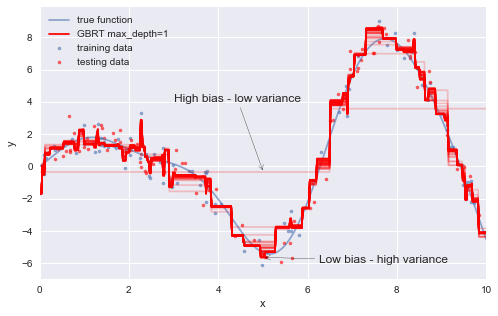

In [13]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from itertools import islice

plot_data()

est = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
est.fit(X_train, y_train)

ax = plt.gca()
first = True

# step over prediction as we added 20 more trees.
for pred in islice(est.staged_predict(x_plot[:, np.newaxis]), 0, 1000, 20):
    
    plt.plot(x_plot, pred, color='r', alpha=0.2)
    
    if first:
        ax.annotate('High bias - low variance', xy=(x_plot[x_plot.shape[0] // 2],
                                                    pred[x_plot.shape[0] // 2]),
                                                    xycoords='data',
                                                    xytext=(3, 4), textcoords='data',
                                                    arrowprops=dict(arrowstyle="->",
                                                                    connectionstyle="arc"))
        first = False

pred = est.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color='r', label='GBRT max_depth=1')
ax.annotate('Low bias - high variance', xy=(x_plot[x_plot.shape[0] // 2],
                                            pred[x_plot.shape[0] // 2]),
                                            xycoords='data', 
                                            xytext=(6.25, -6),
                                            textcoords='data', 
                                            arrowprops=dict(arrowstyle="->",
                                                            connectionstyle="arc"))
plt.legend(loc='upper left');

The above plot shows 50 red lines, each shows the response of the GBRT model after 20 trees have been added. It starts with a very crude approximation that can only fit more-or-less constant functions (ie. _High bias - low variance_) but as we add more trees the more variance our model can capture resulting in the solid red line.

We can see that the more trees we add to our GBRT model and the deeper the individual trees are the more variance we can capture thus the higher the complexity of our model. But as usual in machine learning model complexity trades off variance and bias.

A *deviance plot* shows the training/testing error (or deviance) as a function of the number of trees.

In [14]:
colors = '#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666'

n_estimators = len(est.estimators_)

def deviance_plot(est, X_test, y_test, ax=None, label='', train_color=colors[0], 
                  test_color=colors[1], alpha=1.0):

    test_dev = np.array([est.loss_(y_test, pred) for pred in est.staged_predict(X_test)])

    if ax is None:
        fig = plt.figure(figsize=(8, 5))
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim((0, 2))
    
    return test_dev, ax

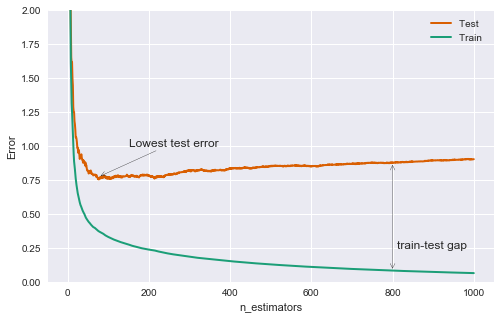

In [15]:
test_dev, ax = deviance_plot(est, X_test, y_test)
ax.legend(loc='upper right')

# add some annotations
ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02), xycoords='data',
            xytext=(150, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )

ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
                  xytext=(800, est.train_score_[799]), textcoords='data',
                  arrowprops=dict(arrowstyle="<->"))
ax.text(810, 0.25, 'train-test gap');

The green line above shows the training error: it rapidly decreases in the beginning and then gradually slows down but keeps decreasing as we add more and more trees. The testing error (upper line) too decreases rapidly in the beginning but then slows down and reaches its minimum fairly early (~50 trees) and then even starts increasing.

An increasing train-test gap is usually a sign of *overfitting*.

The great thing about gradient boosting is that it provides a number of ways to control overfitting.

### Regularization

There are three tuning parameters to consider:

1. The depth and number of trees (boosting can overfit with very large numbers of deep trees)
2. Shrinkage parameter $\lambda$ (typically 0.01 or 0.001; smaller values require more trees to be effective)
3. Randomization

#### Tree Structure

The depth of the individual trees is one aspect of model complexity. The depth of the trees basically control the degree of feature **interactions** that your model can fit. For example, if you want to capture the interaction between a feature ``latitude`` and a feature ``longitude`` your trees need a depth of at least two to capture this. Unfortunately, the degree of feature interactions is not known in advance but it is usually fine to assume that it is faily low; in practice, a depth of 4-6 usually gives the best results. In scikit-learn you can constrain the depth of the trees using the ``max_depth`` argument.

Another way to control the depth of the trees is by enforcing a lower bound on the number of samples in a leaf. This will avoid inbalanced splits where a leaf is formed for just one extreme data point. In scikit-learn you can do this using the argument ``min_samples_leaf``. This is effectively a means to introduce bias into your model with the hope to also reduce variance as shown in the example below:

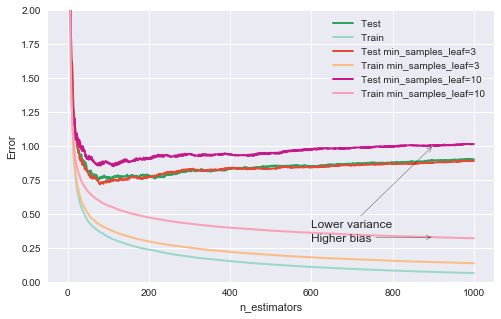

In [16]:
colors = '#2ca25f', '#99d8c9', '#e34a33', '#fdbb84', '#c51b8a', '#fa9fb5'

def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.items())

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
for params, (test_color, train_color) in [({}, (colors[0], colors[1])),
                                          ({'min_samples_leaf': 3},
                                           (colors[2], colors[3])),
                                         ({'min_samples_leaf': 10},
                                           (colors[4], colors[5]))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Higher bias', xy=(900, est.train_score_[899]), xycoords='data',
            xytext=(600, 0.3), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
ax.annotate('Lower variance', xy=(900, test_dev[899]), xycoords='data',
            xytext=(600, 0.4), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right')

#### Shrinkage

The most important regularization technique for GBRT is shrinkage: the idea is basically to do slow learning by strongly shrinking the predictions of each individual tree by some small scalar, the ``learning_rate``. By doing so the model has to re-enforce concepts. A lower ``learning_rate`` requires a higher number of ``n_estimators`` to get to the same level of training error -- so its trading runtime against accuracy.

In [17]:
n_estimators = 6000

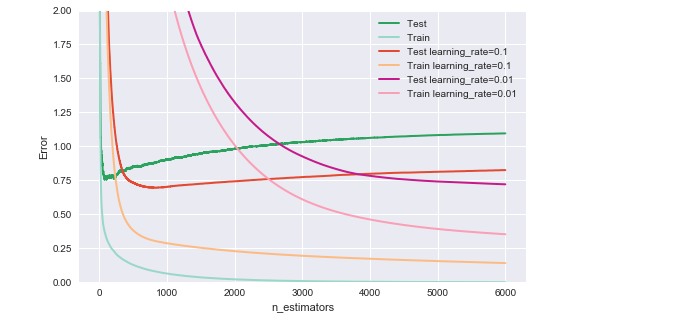

In [18]:
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
for params, (test_color, train_color) in [({}, (colors[0], colors[1])),
                                          ({'learning_rate': 0.1},
                                           (colors[2], colors[3])),
                                         ({'learning_rate': 0.01},
                                           (colors[4], colors[5]))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), xycoords='data',
            xytext=(300, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
ax.annotate('Lower test error', xy=(900, test_dev[899]), xycoords='data',
            xytext=(600, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right')

### Stochastic Gradient Boosting

Similar to random forests, introducing **randomization** into the tree building process can lead to higher accuracy. Scikit-learn provides two ways to introduce randomization: 

1. subsampling the training set before growing each tree (``subsample``) 
2. subsampling the features before finding the best split node (``max_features``).

Subsampling features works better if there is a sufficiently large number of features (>30).

Both options reduce runtime.

Below we show the effect of using ``subsample=0.5``, ie. growing each tree on 50% of the training data,  on our toy example:

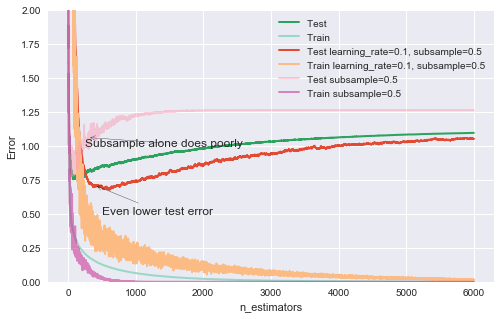

In [19]:
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

for params, (test_color, train_color) in [({}, (colors[0], colors[1])),
                                          ({'learning_rate': 0.1, 'subsample': 0.5},
                                           (colors[2], colors[3]))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0,
                                    random_state=1)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Even lower test error', xy=(400, test_dev[399]), xycoords='data',
            xytext=(500, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )

est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0,
                                subsample=0.5)
est.fit(X_train, y_train)
test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params({'subsample': 0.5}),
                             train_color=colors[4], test_color=colors[5], alpha=0.5)
ax.annotate('Subsample alone does poorly', xy=(300, test_dev[299]), xycoords='data',
            xytext=(250, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right', fontsize='small')

### Hyperparameter tuning

We now have introduced a number of hyperparameters, each of which require selection via optimization, and some of which interact with each other (``learning_rate`` and ``n_estimators``, ``learning_rate`` and ``subsample``, ``max_depth`` and ``max_features``).

We usually follow this recipe to tune the hyperparameters for a gradient boosting model:

  1. Choose ``loss`` based on your problem at hand (i.e. target metric)
  2. Pick ``n_estimators`` as large as (computationally) possible (e.g. 3000).
  3. Tune ``max_depth``, ``learning_rate``, ``min_samples_leaf``, and ``max_features`` via grid search.
  4. Increase ``n_estimators`` even more and tune ``learning_rate`` again holding the other parameters fixed.
    
Scikit-learn provides a convenient API for hyperparameter tuning and grid search:

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              # 'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
              }

est = GradientBoostingRegressor(n_estimators=3000)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 5}

## Example: California Housing

This example shows how to apply GBRT to a real-world dataset. The task is to predict the log median house value for census block groups in California. The dataset is based on the 1990 censues comprising roughly 20.000 groups. There are 8 features for each group including: median income, average house age, latitude, and longitude.

We will use Mean Absolute Error as our target metric and evaluate the results on an 80-20 train-test split.

In [21]:
import pandas as pd

from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_housing = fetch_california_housing()

# split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    np.log(cal_housing.target),
                                                    test_size=0.2,
                                                    random_state=1)
names = cal_housing.feature_names

downloading Cal. housing from http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz to /Users/fonnescj/scikit_learn_data


In [22]:
cal_housing

{'DESCR': 'California housing dataset.\n\nThe original database is available from StatLib\n\n    http://lib.stat.cmu.edu/\n\nThe data contains 20,640 observations on 9 variables.\n\nThis dataset contains the average house value as target variable\nand the following input variables (features): average income,\nhousing average age, average rooms, average bedrooms, population,\naverage occupation, latitude, and longitude in that order.\n\nReferences\n----------\n\nPace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,\nStatistics and Probability Letters, 33 (1997) 291-297.\n\n',
 'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ..., 
        [   1.7       ,   17.        ,    

Some of the aspects that make this dataset challenging are: 

- heterogenous features (different scales and distributions) 
- non-linear feature interactions (specifically latitude and longitude)

Furthermore, the data contains some extreme values of the response (log median house value). Hence, analysis of this dataset will benefit from robust regression techniques.

Below are histograms showing some of the features, along with the response. You can see that they are quite different: median income is left skewed, latitude and longitude are bi-modal, and log median house value is right skewed.

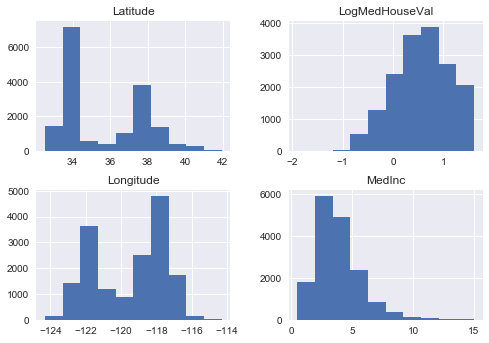

In [23]:
import pandas as pd

X_df = pd.DataFrame(data=X_train, columns=names)
X_df['LogMedHouseVal'] = y_train
_ = X_df.hist(column=['Latitude', 'Longitude', 'MedInc', 'LogMedHouseVal'])

Lets fit a gradient boosteed regression tree (GBRT) model to this dataset and inspect the model:

In [24]:
est = GradientBoostingRegressor(n_estimators=3000, max_depth=6, learning_rate=0.04,
                                loss='huber', random_state=0)
est.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.04, loss='huber', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

Huber loss (`huber`) is a loss function used in robust regression, that is less sensitive to outliers in data than the squared error loss.

$$L_{\delta}(x) = \left\{ \begin{array}{lr}
\frac{1}{2} x^2 & \text{for } |x| \le \delta\\
\delta (|x| - \frac{1}{2} \delta) & \text{otherwise}
\end{array} \right.$$

In [25]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, est.predict(X_test))
print('MAE: %.4f' % mae)

MAE: 0.1458


### Feature importance

Often features do not contribute equally to predict the target response. When interpreting a model, the first question usually is: what are those important features and how do they contributing in predicting the target response?

Feature importance in regression trees can be measured by the amount RSS is decreased due to splits over a given predictor, averaged over all trees.

A GBRT model derives this information from the fitted regression trees which intrinsically perform feature selection by choosing appropriate split points. You can access this information via the instance attribute ``est.feature_importances_``.

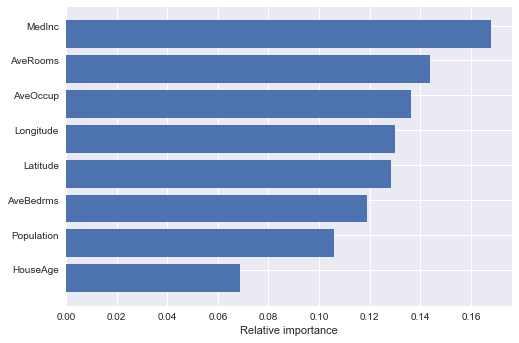

In [26]:
# sort importances
indices = np.argsort(est.feature_importances_)

# plot as bar chart
plt.barh(np.arange(len(names)), est.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

### Partial dependence

Partial dependence plots show the dependence between the response and a set of features, marginalizing over the values of all other features. Intuitively, we can interpret the partial dependence as the expected response as a function of the features we conditioned on.

The plot below contains 4 one-way partial depencence plots (PDP) each showing the effect of an individual feature on the repsonse. We can see that median income ``MedInc`` has a linear relationship with the log median house value.

The contour plot shows a two-way PDP. Here we can see an interesting feature interaction. It seems that house age itself has hardly an effect on the response but when ``AveOccup`` is small it has an effect (the older the house the higher the price).

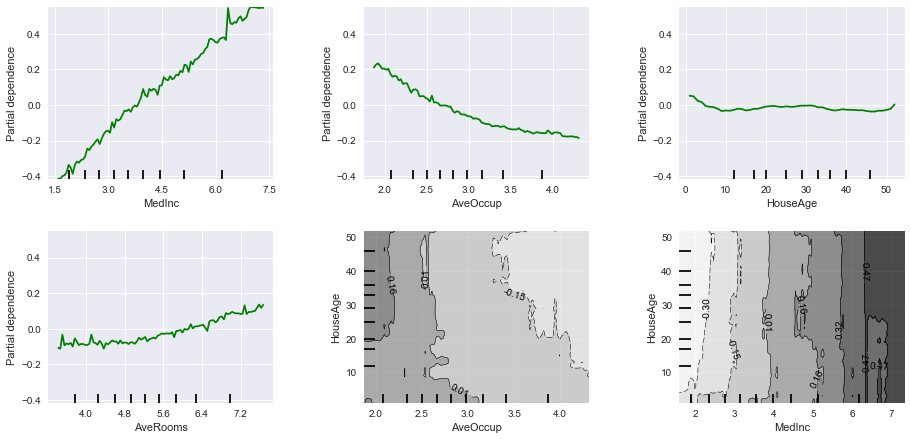

In [27]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms',
            ('AveOccup', 'HouseAge'), ('MedInc', 'HouseAge')]
fig, axs = plot_partial_dependence(est, X_train, features,
                                   feature_names=names, figsize=(14, 10))

Scikit-learn provides a convenience function to create such plots: ``sklearn.ensemble.partial_dependence.plot_partial_dependence`` or a low-level function that you can use to create custom partial dependence plots (e.g. map overlays or 3d plots). 

## Example: Very low birthweight infants

Using the very low birthweight infants dataset we have used previously, build a GBRT to predict the outcome intra-ventricular hemorrhage (`ivh`) from predictors birth weight, gestational age, presence of pneumothorax, mode of delivery, single vs. multiple birth, and whether the birth occurred at Duke or at another hospital with later transfer to Duke. Tune the model, and compare its performance to that of a logistic regression model.

The metadata for this dataset can be found [here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/Cvlbw.html).

In [28]:
import pandas as pd

vlbw = pd.read_csv('../data/vlbw.csv', index_col=0)
vlbw.head()

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,vent,pneumo,pda,cld,pvh,ivh,ipe,year,sex,dead
1,81.511002,81.603996,34.0,NaN,100.0,white,1250.0,35.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,81.511963,female,0
2,81.514000,81.539001,9.0,7.250000,244.0,white,1370.0,32.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,81.514709,female,0
3,81.552002,81.552002,-2.0,7.059998,114.0,black,620.0,23.0,born at Duke,0.0,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,81.553040,female,1
4,81.557999,81.667000,40.0,7.250000,182.0,black,1480.0,32.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,81.558472,male,0
5,81.593002,81.598999,2.0,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,...,1.0,1.0,0.0,0.0,definite,definite,NaN,81.594055,female,1


In [29]:
# Write your answer here

## Random Forest Regressors

Another ensemble method for improving decision tree regression is to employ random forests, so that the
effects of their over-fitting go away on average. 

Here we will use a random forest of 200 trees to reduce the tendency of each
tree to over-fitting the data.

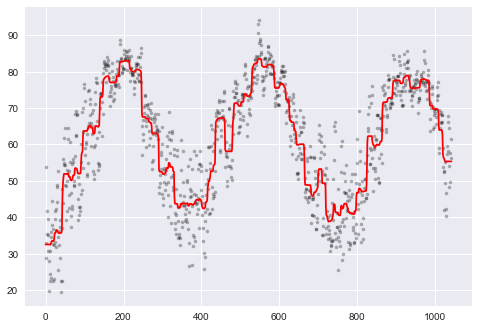

In [34]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=200, max_depth=9, 
                            min_samples_leaf=10)
clf.fit(X, y)

y_fit_200 = clf.predict(X_fit)

plt.plot(X.ravel(), y, '.k', alpha=0.3)
plt.plot(X_fit.ravel(), y_fit_200, color='red')



### Prediction intervals

The predictions from random forests are not accompanied by estimates of uncertainty, as is the case with Bayesian regression models. However, it is possible to obtain probability intervals using a random forests approach. Since we are using an ensemble of trees, it is possible to track *all* predicted values for all leaf nodes in a random forest, rather than just the mean or modal value. This results in conditional distributions $P(y|X=x)$ for every x, from which percentiles can be calculated for desired endpoints in a prediction interval. This approach is called **quantile regression forests**.

To implement quantile regression forests in scikit-learn, we need to allow each tree to grow so that each leaf node contains exactly one value. Then, each tree returns a single response variable, from which a conditional distribution can be approximated. Of course, fully expanding trees will result in overfitting, but these can also be cross-validated.

scikit-learn does not automatically calculate prediction intervals, but the estimators from each constitutent tree in the `RandomForestRegressor` is avaialable, from which individual tree predictions can be made.

In [35]:
def prediction_intervals(mod, X, alpha=0.05):
    preds = [pred.predict(X) for pred in mod.estimators_]
    lower = np.percentile(preds, 100*(alpha/2), axis=0)
    upper = np.percentile(preds, 100*(1-alpha/2), axis=0)
    return lower, upper, np.array(preds)

In [37]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.4, random_state=0)

In [38]:
clf = RandomForestRegressor(n_estimators=1000, min_samples_leaf=1)
clf.fit(X_train, y_train)

y_fit_200 = clf.predict(X_fit)

In [39]:
lower, upper, preds = prediction_intervals(clf, X_test, alpha=0.1)

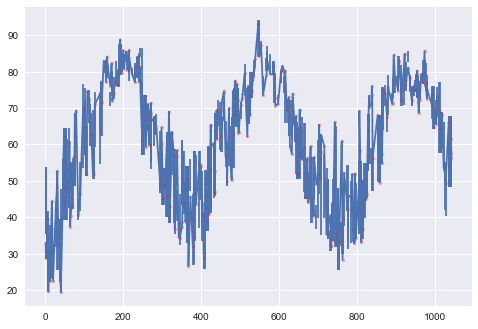

In [40]:
x_sorted = np.sort(X_test.ravel())
order = np.argsort(X_test.ravel())
plt.errorbar(x_sorted, y_test.values[order], 
             yerr=[(y_test.values-lower)[order], (upper-y_test.values)[order]])
plt.plot(X_test, y_test, '.r', alpha=0.3)

### Exercise

Selecting the optimal random forest regression model for the nashville daily temperature data via cross-validation in `scikit-learn`. Use the number of estimators and the maximim leaf nodes as tuning parameters.

In [41]:
# Write your answer here

## References 

T. Hastie, R. Tibshirani and J. Friedman. (2009) [Elements of Statistical Learning: Data Mining, Inference, and Prediction](http://statweb.stanford.edu/~tibs/ElemStatLearn/), second edition. Springer.

S. Marsland. (2009) [Machine Learning: An Algorithmic Perspective](Machine Learning: An Algorithmic Perspectivehttp://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html). CRC Press.

Data Robot Blog: [Gradient Boosted Regression Trees](http://www.datarobot.com/blog/gradient-boosted-regression-trees/)